In [1]:
import pickle
import os
import pandas as pd
from matplotlib import pyplot as plt
os.chdir(os.path.expanduser('~/wcEcoli/'))
# noinspection PyUnresolvedReferences
import numpy as np
import plotly.graph_objects as go
from models.ecoli.analysis import cohortAnalysisPlot
from wholecell.analysis.analysis_tools import (exportFigure,
	read_bulk_molecule_counts, read_stacked_bulk_molecules, read_stacked_columns)
from wholecell.io.tablereader import TableReader
from sklearn.metrics import r2_score
import plotly.graph_objects as go
import glob
import plotly.express as px

read in the priority substrate data

In [2]:
# read in the priority protease data: 
priority_substrates = "models/ecoli/analysis/local_notebooks/protease_substrate_relationships/data/priority_protease_assignments_0.tsv"
priority_substrates = pd.read_csv(priority_substrates, sep='\t', skiprows=1)


common_names = "reconstruction/ecoli/scripts/protein_half_lives/Gupta_et_al_Clim_data/Clim_EcoCyc_monomer_ID_matches/41467_2024_49920_MOESM4_ESM_ST1_EcoCyc_monomer_ID_matches_11202024.tsv"
common_names = pd.read_csv(common_names, sep='\t', skiprows=1)

priority_substrates['common_name'] = None
for index, row in priority_substrates.iterrows():
    if row['id'] in common_names['Monomer ID'].values:
        priority_substrates.at[index, 'common_name'] = common_names[common_names['Monomer ID'] == row['id']]['Common Name'].values[0]
priority_substrates

,id,protease_assignment,ClpP,Lon,HslV,Unexplained,common_name
0,EG10156-MONOMER,ClpP only,1.000000,0.000000,0.000000,0.000000,clpA
1,MDLB-MONOMER,ClpP only,1.000000,0.000000,0.000000,0.000000,mdlB
2,EG10927-MONOMER,ClpP only,1.000000,0.000000,0.000000,0.000000,sbcC
3,EG10618-MONOMER,ClpP only,1.000000,0.000000,0.000000,0.000000,mukB
4,AERGLYC3PDEHYDROG-MONOMER,ClpP only,0.993731,0.000000,0.000000,0.000000,glpD
...,...,...,...,...,...,...,...
77,EG12690-MONOMER,"Additive: ClpP, Lon, HslV",0.277972,0.277364,0.378556,0.066108,rarA
78,PD03831,"Additive: ClpP, Lon",0.519958,0.403122,0.000000,0.076920,dnaA
79,AROK-MONOMER,"Additive: ClpP, Lon, HslV",0.319436,0.429511,0.167152,0.083901,aroK
80,G7263-MONOMER,"Additive: ClpP, Lon, HslV",0.183526,0.206054,0.520932,0.089488,murQ


In [3]:
# remove the common name column from the priority substrates data frame:
priority_substrates = priority_substrates.drop(columns=['common_name'])
priority_substrates

,id,protease_assignment,ClpP,Lon,HslV,Unexplained
0,EG10156-MONOMER,ClpP only,1.000000,0.000000,0.000000,0.000000
1,MDLB-MONOMER,ClpP only,1.000000,0.000000,0.000000,0.000000
2,EG10927-MONOMER,ClpP only,1.000000,0.000000,0.000000,0.000000
3,EG10618-MONOMER,ClpP only,1.000000,0.000000,0.000000,0.000000
4,AERGLYC3PDEHYDROG-MONOMER,ClpP only,0.993731,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
77,EG12690-MONOMER,"Additive: ClpP, Lon, HslV",0.277972,0.277364,0.378556,0.066108
78,PD03831,"Additive: ClpP, Lon",0.519958,0.403122,0.000000,0.076920
79,AROK-MONOMER,"Additive: ClpP, Lon, HslV",0.319436,0.429511,0.167152,0.083901
80,G7263-MONOMER,"Additive: ClpP, Lon, HslV",0.183526,0.206054,0.520932,0.089488


read in the half life data from CLNE1 (original model)

In [4]:
# read in the CLNE1 half life data: 
CLNE1_HLs = "out/CLNE1/kb_plot_out/protein_half_lives.tsv"
CLNE1_HLs = pd.read_csv(CLNE1_HLs, sep='\t')
CLNE1_HLs

,monomer_id,degradation_rate(1/s),half_life_(min),degradation_rate_source
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,0.000019,600.0,N_end_rule
1,1-PFK-MONOMER,0.000019,600.0,N_end_rule
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,0.000019,600.0,N_end_rule
3,2-ISOPROPYLMALATESYN-MONOMER,0.000019,600.0,N_end_rule
4,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,0.000019,600.0,N_end_rule
...,...,...,...,...
4305,YTFR-MONOMER,0.000019,600.0,N_end_rule
4306,YTFT-MONOMER,0.000019,600.0,N_end_rule
4307,ZNUA-MONOMER,0.000019,600.0,N_end_rule
4308,ZNUB-MONOMER,0.000019,600.0,N_end_rule


In [5]:
# make a new data frame that contains the monomers that only have a half life of 600 in the half_life_(min) column of CLNE1_HLs:
CLNE1_HLs_600 = CLNE1_HLs[CLNE1_HLs['half_life_(min)'] == 600]
CLNE1_HLs_600

,monomer_id,degradation_rate(1/s),half_life_(min),degradation_rate_source
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,0.000019,600.0,N_end_rule
1,1-PFK-MONOMER,0.000019,600.0,N_end_rule
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,0.000019,600.0,N_end_rule
3,2-ISOPROPYLMALATESYN-MONOMER,0.000019,600.0,N_end_rule
4,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,0.000019,600.0,N_end_rule
...,...,...,...,...
4305,YTFR-MONOMER,0.000019,600.0,N_end_rule
4306,YTFT-MONOMER,0.000019,600.0,N_end_rule
4307,ZNUA-MONOMER,0.000019,600.0,N_end_rule
4308,ZNUB-MONOMER,0.000019,600.0,N_end_rule


In [6]:
# make a new data frame that contains the monomers that only have a half life of 2 in the half_life_(min) column of CLNE1_HLs:
CLNE1_HLs_2 = CLNE1_HLs[CLNE1_HLs['half_life_(min)'] == 2]
CLNE1_HLs_2
# note, the remianing half lives are Covert lab assigned half lives!

,monomer_id,degradation_rate(1/s),half_life_(min),degradation_rate_source
517,EG10506-MONOMER,0.005776,2.0,N_end_rule
611,EG10765-MONOMER,0.005776,2.0,N_end_rule
2754,G7426-MONOMER,0.005776,2.0,N_end_rule
3293,ISOCIT-LYASE-MONOMER,0.005776,2.0,N_end_rule
3787,OROPRIBTRANS-MONOMER,0.005776,2.0,N_end_rule
3887,PGPPHOSPHAB-MONOMER,0.005776,2.0,N_end_rule
3927,PPENTOMUT-MONOMER,0.005776,2.0,N_end_rule


read in the half life data from CLClim3NE1 (new proposed sort)

In [7]:
# read in the CLClim3NE1 half life data:
CLClim3NE1_HLs = "out/CLClim3NE1/kb_plot_out/protein_half_lives.tsv"
CLClim3NE1_HLs = pd.read_csv(CLClim3NE1_HLs, sep='\t')
CLClim3NE1_HLs

# count how many monomers are assigned to Gupta et al. MS 2024 data in the degradation rate source column:
CLClim3NE1_HLs[CLClim3NE1_HLs['degradation_rate_source'] == "N_end_rule"]

,monomer_id,degradation_rate(1/s),half_life_(min),degradation_rate_source
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,0.000019,600.0,N_end_rule
19,ABGT-MONOMER,0.000019,600.0,N_end_rule
30,ACPSUB-MONOMER,0.000019,600.0,N_end_rule
33,ACRF-MONOMER,0.000019,600.0,N_end_rule
51,AGAC-MONOMER,0.000019,600.0,N_end_rule
...,...,...,...,...
4299,YPHE-MONOMER,0.000019,600.0,N_end_rule
4301,YRBE-MONOMER,0.000019,600.0,N_end_rule
4303,YRBG-MONOMER,0.000019,600.0,N_end_rule
4306,YTFT-MONOMER,0.000019,600.0,N_end_rule


add the common name to the data frame too:

In [8]:
common_names = "reconstruction/ecoli/scripts/protein_half_lives/Gupta_et_al_Clim_data/Clim_EcoCyc_monomer_ID_matches/41467_2024_49920_MOESM4_ESM_ST1_EcoCyc_monomer_ID_matches_11202024.tsv"
common_names = pd.read_csv(common_names, sep='\t', skiprows=1)

CLClim3NE1_HLs['common_name'] = None
for index, row in CLClim3NE1_HLs.iterrows():
    if row['monomer_id'] in common_names['Monomer ID'].values:
        CLClim3NE1_HLs.at[index, 'common_name'] = common_names[common_names['Monomer ID'] == row['monomer_id']]['Common Name'].values[0]
   
CLClim3NE1_HLs

,monomer_id,degradation_rate(1/s),half_life_(min),degradation_rate_source,common_name
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,0.000023,501.707893,Gupta_et_al_MS_2024,plsC
1,1-PFK-MONOMER,0.000015,766.256894,Gupta_et_al_MS_2024,fruK
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,0.000019,600.000000,N_end_rule,panE
3,2-ISOPROPYLMALATESYN-MONOMER,0.000042,276.924332,Gupta_et_al_MS_2024,leuA
4,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,0.000023,493.397050,Gupta_et_al_MS_2024,ubiE
...,...,...,...,...,...
4305,YTFR-MONOMER,0.000018,654.149344,Gupta_et_al_MS_2024,ytfR
4306,YTFT-MONOMER,0.000019,600.000000,N_end_rule,ytfT
4307,ZNUA-MONOMER,0.000018,638.129701,Gupta_et_al_MS_2024,znuA
4308,ZNUB-MONOMER,0.000019,600.000000,N_end_rule,None


In [9]:
# make a new column in the CLClim3NE1_HLs_Clim3 data frame that contains the monomer_id's that are priority substrates:

CLClim3NE1_HLs['protease_assignment'] = "None"
for index, row in CLClim3NE1_HLs.iterrows():
    if row['monomer_id'] in priority_substrates['id'].values:
        CLClim3NE1_HLs.at[index, 'protease_assignment'] = priority_substrates[priority_substrates['id'] == row['monomer_id']]['protease_assignment'].values[0]
        #CLClim3NE1_HLs_Clim3.at[index, 'common_names'] = priority_substrates[priority_substrates['id'] == row['monomer_id']]['common_name'].values[0]
   
CLClim3NE1_HLs

,monomer_id,degradation_rate(1/s),half_life_(min),degradation_rate_source,common_name,protease_assignment
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,0.000023,501.707893,Gupta_et_al_MS_2024,plsC,None
1,1-PFK-MONOMER,0.000015,766.256894,Gupta_et_al_MS_2024,fruK,None
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,0.000019,600.000000,N_end_rule,panE,None
3,2-ISOPROPYLMALATESYN-MONOMER,0.000042,276.924332,Gupta_et_al_MS_2024,leuA,None
4,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,0.000023,493.397050,Gupta_et_al_MS_2024,ubiE,None
...,...,...,...,...,...,...
4305,YTFR-MONOMER,0.000018,654.149344,Gupta_et_al_MS_2024,ytfR,None
4306,YTFT-MONOMER,0.000019,600.000000,N_end_rule,ytfT,None
4307,ZNUA-MONOMER,0.000018,638.129701,Gupta_et_al_MS_2024,znuA,None
4308,ZNUB-MONOMER,0.000019,600.000000,N_end_rule,None,None


Find the proteins in the CLClim3NE1_HLs data frame that have a half life of 600 in the half_life_(min) column

In [10]:
# make a new data frame from CLCLim3NE1_HLs that contains only the monomers that show up in CLNE1_HLs_600:
CLClim3NE1_HLs_were_600 = CLNE1_HLs_600.merge(CLClim3NE1_HLs, on='monomer_id', how='inner')
# remove columns 2, 3, and 4 from the data frame:
CLClim3NE1_HLs_were_600 = CLClim3NE1_HLs_were_600.drop(columns=['half_life_(min)_x', 'degradation_rate(1/s)_x', 'degradation_rate_source_x'])


CLClim3NE1_HLs_were_600 # 4296
# note that the other 600 min rate in here is the CL_measured_deg_rates_2020 rate for CdsA I think. So dont count that in here since it is not being reassigned. 


,monomer_id,degradation_rate(1/s)_y,half_life_(min)_y,degradation_rate_source_y,common_name,protease_assignment
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,0.000023,501.707893,Gupta_et_al_MS_2024,plsC,None
1,1-PFK-MONOMER,0.000015,766.256894,Gupta_et_al_MS_2024,fruK,None
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,0.000019,600.000000,N_end_rule,panE,None
3,2-ISOPROPYLMALATESYN-MONOMER,0.000042,276.924332,Gupta_et_al_MS_2024,leuA,None
4,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,0.000023,493.397050,Gupta_et_al_MS_2024,ubiE,None
...,...,...,...,...,...,...
4291,YTFR-MONOMER,0.000018,654.149344,Gupta_et_al_MS_2024,ytfR,None
4292,YTFT-MONOMER,0.000019,600.000000,N_end_rule,ytfT,None
4293,ZNUA-MONOMER,0.000018,638.129701,Gupta_et_al_MS_2024,znuA,None
4294,ZNUB-MONOMER,0.000019,600.000000,N_end_rule,None,None


find the proteins that were 2 mins in the original model:

In [11]:
# make a new data frame from CLCLim3NE1_HLs that contains only the monomers that show up in CLNE1_HLs_2:
CLClim3NE1_HLs_were_2 = CLNE1_HLs_2.merge(CLClim3NE1_HLs, on='monomer_id', how='inner')
# remove columns 2, 3, and 4 from the data frame:
CLClim3NE1_HLs_were_2 = CLClim3NE1_HLs_were_2.drop(columns=['half_life_(min)_x', 'degradation_rate(1/s)_x', 'degradation_rate_source_x'])


CLClim3NE1_HLs_were_2 # 7



,monomer_id,degradation_rate(1/s)_y,half_life_(min)_y,degradation_rate_source_y,common_name,protease_assignment
0,EG10506-MONOMER,0.000018,659.511001,Gupta_et_al_MS_2024,infC,None
1,EG10765-MONOMER,0.000050,229.584501,Gupta_et_al_MS_2024,priC,None
2,G7426-MONOMER,0.000120,96.304300,Gupta_et_al_MS_2024,casE,None
3,ISOCIT-LYASE-MONOMER,0.000023,506.342742,Gupta_et_al_MS_2024,aceA,None
4,OROPRIBTRANS-MONOMER,0.000021,558.233686,Gupta_et_al_MS_2024,pyrE,None
5,PGPPHOSPHAB-MONOMER,0.000012,935.775109,Gupta_et_al_MS_2024,pgpB,None
6,PPENTOMUT-MONOMER,0.000021,553.128667,Gupta_et_al_MS_2024,deoB,None


find the proteins that still are 600 mins in the new model

In [12]:
CLClim3NE1_HLs_still_600 = CLClim3NE1_HLs_were_600[CLClim3NE1_HLs_were_600['degradation_rate_source_y'] == "N_end_rule"]
CLClim3NE1_HLs_still_600 # 1628

,monomer_id,degradation_rate(1/s)_y,half_life_(min)_y,degradation_rate_source_y,common_name,protease_assignment
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,0.000019,600.0,N_end_rule,panE,None
19,ABGT-MONOMER,0.000019,600.0,N_end_rule,None,None
30,ACPSUB-MONOMER,0.000019,600.0,N_end_rule,citD,None
33,ACRF-MONOMER,0.000019,600.0,N_end_rule,acrF,None
51,AGAC-MONOMER,0.000019,600.0,N_end_rule,None,None
...,...,...,...,...,...,...
4285,YPHE-MONOMER,0.000019,600.0,N_end_rule,yphE,None
4287,YRBE-MONOMER,0.000019,600.0,N_end_rule,mlaE,None
4289,YRBG-MONOMER,0.000019,600.0,N_end_rule,yrbG,None
4292,YTFT-MONOMER,0.000019,600.0,N_end_rule,ytfT,None


find the proteins that are no longer 600 mins in the new model

In [13]:
CLClim3NE1_HLs_Clim3 = CLClim3NE1_HLs_were_600[CLClim3NE1_HLs_were_600['degradation_rate_source_y'] == "Gupta_et_al_MS_2024"]
CLClim3NE1_HLs_Clim3 # 2667

,monomer_id,degradation_rate(1/s)_y,half_life_(min)_y,degradation_rate_source_y,common_name,protease_assignment
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,0.000023,501.707893,Gupta_et_al_MS_2024,plsC,None
1,1-PFK-MONOMER,0.000015,766.256894,Gupta_et_al_MS_2024,fruK,None
3,2-ISOPROPYLMALATESYN-MONOMER,0.000042,276.924332,Gupta_et_al_MS_2024,leuA,None
4,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,0.000023,493.397050,Gupta_et_al_MS_2024,ubiE,None
5,2-OCTAPRENYLPHENOL-HYDROX-MONOMER,0.000015,796.038829,Gupta_et_al_MS_2024,ubiB,None
...,...,...,...,...,...,...
4288,YRBF-MONOMER,0.000014,823.833163,Gupta_et_al_MS_2024,mlaF,None
4290,YTFQ-MONOMER,0.000015,790.418789,Gupta_et_al_MS_2024,ytfQ,None
4291,YTFR-MONOMER,0.000018,654.149344,Gupta_et_al_MS_2024,ytfR,None
4293,ZNUA-MONOMER,0.000018,638.129701,Gupta_et_al_MS_2024,znuA,None


Plot the new half life values for proteins that were originally 600 mins in the CLNE1 model and are now assigned to a Clim3 half life in the CLClim3NE1 model

Now, split up the substrates by protease assignment

In [14]:
# rename the columns in the CLClim3NE1_HLs_Clim3 data frame:
CLClim3NE1_HLs_Clim3 = CLClim3NE1_HLs_Clim3.rename(columns={"half_life_(min)_y": "half_life_(min)", "degradation_rate(1/s)_y": "degradation_rate(1/s)", "degradation_rate_source_y": "degradation_rate_source"})   

CLClim3NE1_HLs_Clim3_sorted = CLClim3NE1_HLs_Clim3.sort_values(by=["half_life_(min)"])
ordered_CLClimNE_Clim_10 = CLClim3NE1_HLs_Clim3_sorted.copy()

# figure out which proteins were assigned to lon in the model: 
lon_proteins = ordered_CLClimNE_Clim_10[ordered_CLClimNE_Clim_10['protease_assignment'] == 'Lon only']
lon_proteins

# figure out which proteins were assigned to clp in the model:
clp_proteins = ordered_CLClimNE_Clim_10[ordered_CLClimNE_Clim_10['protease_assignment'] == 'ClpP only']

hslv_proteins = ordered_CLClimNE_Clim_10[ordered_CLClimNE_Clim_10['protease_assignment'] == 'HslV only']

# figure out which proteins are additive in the model: 
additive_proteins_LC = ordered_CLClimNE_Clim_10[ordered_CLClimNE_Clim_10['protease_assignment'] == 'Additive: ClpP, Lon']

# figure out which proteins are additive in the model: 
additive_proteins_LCH = ordered_CLClimNE_Clim_10[ordered_CLClimNE_Clim_10['protease_assignment'] == 'Additive: ClpP, Lon, HslV']

# figure out which proteins were not assigned to a protease in the model:
no_protease_proteins = ordered_CLClimNE_Clim_10[ordered_CLClimNE_Clim_10['protease_assignment'] == 'None']
print()

# todo: note that these numbers will not add up to those in the graph below bc some proteins in the CLClim0NE model are not in the CLNE model 
#298 total 
print("Lon Proteins (" +str(len(lon_proteins))+"): ", list(lon_proteins['common_name'])) #6
print("ClpP Proteins (" +str(len(clp_proteins))+"): ", list(clp_proteins['common_name'])) #39
print("HslV Proteins (" +str(len(hslv_proteins))+"): ", list(hslv_proteins['common_name'])) #1
print("Additive (Lon + ClpP) Proteins (" +str(len(additive_proteins_LC))+"): ", list(additive_proteins_LC['common_name'])) #3
print("Additive (Lon + ClpP + HslV) Proteins (" +str(len(additive_proteins_LCH))+"): ", list(additive_proteins_LCH['common_name'])) #32

# figure out slices of the data:
ordered_CLClimNE_Clim_10_copy = ordered_CLClimNE_Clim_10.copy()
# make a copy of the ordered_df data:
CLClimNE_full_log_data_with_Lon_proteases = ordered_CLClimNE_Clim_10_copy.copy()
CLClimNE_full_log_data_with_ClpP_proteases = ordered_CLClimNE_Clim_10_copy.copy()
CLClimNE_full_log_data_with_HslV_proteases = ordered_CLClimNE_Clim_10_copy.copy()
CLClimNE_full_log_data_with_Additive_LC_proteases = ordered_CLClimNE_Clim_10_copy.copy()
CLClimNE_full_log_data_with_Additive_LCH_proteases = ordered_CLClimNE_Clim_10_copy.copy()
CLClimNE_full_log_data_with_no_proteases = ordered_CLClimNE_Clim_10_copy.copy()

# remove the proteins that were not assigned to the protease in the model:
CLClimNE_full_log_data_with_Lon_proteases = CLClimNE_full_log_data_with_Lon_proteases[CLClimNE_full_log_data_with_Lon_proteases['protease_assignment'] == 'Lon only']
CLClimNE_full_log_data_with_ClpP_proteases = CLClimNE_full_log_data_with_ClpP_proteases[CLClimNE_full_log_data_with_ClpP_proteases['protease_assignment'] == 'ClpP only']
CLClimNE_full_log_data_with_HslV_proteases = CLClimNE_full_log_data_with_HslV_proteases[CLClimNE_full_log_data_with_HslV_proteases['protease_assignment'] == 'HslV only']
CLClimNE_full_log_data_with_Additive_LC_proteases = CLClimNE_full_log_data_with_Additive_LC_proteases[CLClimNE_full_log_data_with_Additive_LC_proteases['protease_assignment'] == 'Additive: ClpP, Lon']
CLClimNE_full_log_data_with_Additive_LCH_proteases = CLClimNE_full_log_data_with_Additive_LCH_proteases[CLClimNE_full_log_data_with_Additive_LCH_proteases['protease_assignment'] == 'Additive: ClpP, Lon, HslV']

priority_substrates_in_the_full_model = [CLClimNE_full_log_data_with_Lon_proteases, CLClimNE_full_log_data_with_ClpP_proteases, CLClimNE_full_log_data_with_HslV_proteases, CLClimNE_full_log_data_with_Additive_LC_proteases, CLClimNE_full_log_data_with_Additive_LCH_proteases]

# concatenate the dataframes:
priority_substrates_full_model_df = pd.concat(priority_substrates_in_the_full_model)
priority_substrates_full_model_df

# note this is missing rutA (we do not reassign it a HL with Clim3 data but it is a priority substrate)


Lon Proteins (6):  ['metR', 'nemA', 'ydcI', 'trxC', 'fhlA', 'rpoD']
ClpP Proteins (39):  ['phoH', 'rpoS', 'intA', 'clpA', 'patA', 'ribB', 'clpX', 'ftsZ', 'ydhQ', 'cysD', 'fadE', 'putA', 'nfo', 'dps', 'yfcZ', 'comR', 'exuR', 'glpD', 'dksA', 'lldD', 'obgE', 'parC', 'yheS', 'def', 'pcnB', 'yheO', 'rpoC', 'znuC', 'mukB', 'mdlB', 'uvrD', 'dnaB', 'mutS', 'rpsA', 'dnaK', 'sbcC', 'oxyR', 'rpoB', 'recA']
HslV Proteins (1):  ['uhpA']
Additive (Lon + ClpP) Proteins (3):  ['ibpA', 'grcA', 'dnaA']
Additive (Lon + ClpP + HslV) Proteins (32):  ['iscR', 'erpA', 'yibA', 'glaR', 'aroK', 'chaB', 'minE', 'yfhH', 'yaeP', 'proQ', 'ybaB', 'parE', 'yjgA', 'yiiQ', 'murQ', 'yihD', 'glnD', 'helD', 'mazF', 'ppiC', 'pspA', 'acpP', 'yggX', 'srmB', 'ycaR', 'rarA', 'ligA', 'rhlB', 'kbp', 'thiL', 'hprR', 'yiaU']


,monomer_id,degradation_rate(1/s),half_life_(min),degradation_rate_source,common_name,protease_assignment
3851,PD03938,0.000146,79.151002,Gupta_et_al_MS_2024,metR,Lon only
2334,G6890-MONOMER,0.000054,214.018094,Gupta_et_al_MS_2024,nemA,Lon only
2221,G6737-MONOMER,0.000040,288.738238,Gupta_et_al_MS_2024,ydcI,Lon only
3963,RED-THIOREDOXIN2-MONOMER,0.000031,367.223275,Gupta_et_al_MS_2024,trxC,Lon only
3842,PD02936,0.000025,468.602732,Gupta_et_al_MS_2024,fhlA,Lon only
...,...,...,...,...,...,...
633,EG10844-MONOMER,0.000018,624.526702,Gupta_et_al_MS_2024,rhlB,"Additive: ClpP, Lon, HslV"
2721,G7395-MONOMER,0.000018,635.846404,Gupta_et_al_MS_2024,kbp,"Additive: ClpP, Lon, HslV"
4058,THI-P-KIN-MONOMER,0.000018,656.519837,Gupta_et_al_MS_2024,thiL,"Additive: ClpP, Lon, HslV"
2467,G7057-MONOMER,0.000018,656.623355,Gupta_et_al_MS_2024,hprR,"Additive: ClpP, Lon, HslV"


Plot the half life values for proteins that were originally 10 hours in the CLNE1 model and are now assigned to a Clim3 half life in the CLClim3NE1 model

In [15]:
# todo: figure out what is up with EG12298 because it used to have a HL of 7k mins or something!

In [16]:
# Clim3 HL plot!

fig = go.Figure()

# generate the figure in the background first:
fig = px.scatter(ordered_CLClimNE_Clim_10, x=ordered_CLClimNE_Clim_10["monomer_id"], y=ordered_CLClimNE_Clim_10["half_life_(min)"])
fig.update_traces(marker_size=.01, opacity=.01)    

# figure out slices of the data:
priority_protease_df = ordered_CLClimNE_Clim_10.copy()
# make a copy of the ordered_df data:
CLClimNE_Clim0_log_data_with_Lon_proteases = priority_protease_df.copy()
CLClimNE_Clim0_log_data_with_ClpP_proteases = priority_protease_df.copy()
CLClimNE_Clim0_log_data_with_HslV_proteases = priority_protease_df.copy()
CLClimNE_Clim0_log_data_with_Additive_LC_proteases = priority_protease_df.copy()
CLClimNE_Clim0_log_data_with_Additive_LCH_proteases = priority_protease_df.copy()
CLClimNE_Clim0_log_data_with_no_protease_proteases = priority_protease_df.copy()

# remove the proteins that were not assigned to the protease in the model:
CLClimNE_log_data_with_Lon_proteases = CLClimNE_Clim0_log_data_with_Lon_proteases[CLClimNE_Clim0_log_data_with_Lon_proteases['protease_assignment'] == 'Lon only']
CLClimNE_log_data_with_ClpP_proteases = CLClimNE_Clim0_log_data_with_ClpP_proteases[CLClimNE_Clim0_log_data_with_ClpP_proteases['protease_assignment'] == 'ClpP only']
CLClimNE_log_data_with_HslV_proteases = CLClimNE_Clim0_log_data_with_HslV_proteases[CLClimNE_Clim0_log_data_with_HslV_proteases['protease_assignment'] == 'HslV only']
CLClimNE_Clim0_log_data_with_Additive_LC_proteases = CLClimNE_Clim0_log_data_with_Additive_LC_proteases[CLClimNE_Clim0_log_data_with_Additive_LC_proteases['protease_assignment'] == 'Additive: ClpP, Lon']
CLClimNE_Clim0_log_data_with_Additive_LCH_proteases = CLClimNE_Clim0_log_data_with_Additive_LCH_proteases[CLClimNE_Clim0_log_data_with_Additive_LCH_proteases['protease_assignment'] == 'Additive: ClpP, Lon, HslV']
CLClimNE_log_data_with_no_protease_proteases = CLClimNE_Clim0_log_data_with_no_protease_proteases[CLClimNE_Clim0_log_data_with_no_protease_proteases['protease_assignment'] == 'None']

# overlay the individual rates
fig.add_trace(go.Scatter(x=(CLClimNE_log_data_with_no_protease_proteases['monomer_id']), y=(CLClimNE_log_data_with_no_protease_proteases["half_life_(min)"]), mode='markers', name=("No assignment"+ ' '+ (str(np.shape(CLClimNE_log_data_with_no_protease_proteases['monomer_id'])[0]))), hovertext=CLClimNE_log_data_with_no_protease_proteases['common_name'], marker_size=2, marker=dict(color="lightseagreen", size=3, opacity=.2), yaxis="y1"))

fig.add_trace(go.Scatter(x=(CLClimNE_Clim0_log_data_with_Additive_LC_proteases['monomer_id']), y=(CLClimNE_Clim0_log_data_with_Additive_LC_proteases["half_life_(min)"]), mode='markers', name=("Additive: ClpP, Lon "+ (str(np.shape(CLClimNE_Clim0_log_data_with_Additive_LC_proteases['monomer_id'])[0]))), hovertext=CLClimNE_Clim0_log_data_with_Additive_LC_proteases['common_name'], marker_size=4, marker=dict(color='mediumturquoise', size=3, opacity=1), yaxis="y1"))

fig.add_trace(go.Scatter(x=(CLClimNE_Clim0_log_data_with_Additive_LCH_proteases['monomer_id']), y=(CLClimNE_Clim0_log_data_with_Additive_LCH_proteases["half_life_(min)"]), mode='markers', name=("Additive: ClpP, Lon, HslV "+ (str(np.shape(CLClimNE_Clim0_log_data_with_Additive_LCH_proteases['monomer_id'])[0]))), hovertext=CLClimNE_Clim0_log_data_with_Additive_LCH_proteases['common_name'], marker_size=4, marker=dict(color='orange', size=3, opacity=.6), yaxis="y1"))

fig.add_trace(go.Scatter(x=(CLClimNE_log_data_with_ClpP_proteases['monomer_id']), y=(CLClimNE_log_data_with_ClpP_proteases["half_life_(min)"]), mode='markers', name=("ClpP  "+ (str(np.shape(CLClimNE_log_data_with_ClpP_proteases['monomer_id'])[0]))), hovertext=CLClimNE_log_data_with_ClpP_proteases['common_name'], marker_size=3, marker=dict(color='deeppink', size=3, opacity=.4), yaxis="y1"))

fig.add_trace(go.Scatter(x=(CLClimNE_log_data_with_Lon_proteases['monomer_id']), y=(CLClimNE_log_data_with_Lon_proteases["half_life_(min)"]), mode='markers', name=("Lon  "+ (str(np.shape(CLClimNE_log_data_with_Lon_proteases['monomer_id'])[0]))), hovertext=CLClimNE_log_data_with_Lon_proteases['common_name'], marker_size=5, marker=dict(color="yellowgreen", size=3, opacity=.8), yaxis="y1"))

fig.add_trace(go.Scatter(x=(CLClimNE_log_data_with_HslV_proteases['monomer_id']), y=(CLClimNE_log_data_with_HslV_proteases["half_life_(min)"]), mode='markers', name=("HslV  "+ (str(np.shape(CLClimNE_log_data_with_HslV_proteases['monomer_id'])[0]))), hovertext=CLClimNE_log_data_with_HslV_proteases['common_name'], marker_size=5, marker=dict(color="brown", size=3, opacity=.6), yaxis="y1"))
            
            
# Plot Specs
fig.update_layout(title=dict(text=f'The C-limited (Clim) half life values for the New WCM (CLClim3NE1) proteins assigned to Clim3 <br> half-lives that were assinged to a half-life of 10 hours in the original model (CLNE1) ', font=dict(size=15)), xaxis_title='Protein ID', yaxis_title='Clim Half Life (min)')
fig.update_xaxes(visible=False)
fig.update_layout(autosize=False, width=900, height=600, showlegend=True)

# wont open in pycharm, so save as a html:
out_pth = "models/ecoli/analysis/local_notebooks/protease_substrate_relationships/CLClim3NE1_Clim3_HLs_that_were_600_in_CLNE1.html" 
out_pth = os.path.expanduser(out_pth) 
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
fig.write_html(out_pth, auto_open=True) # displays the figure on a default web browser 


In [17]:

fig = go.Figure()

# generate the figure in the background first:
fig = px.scatter(ordered_CLClimNE_Clim_10, x=ordered_CLClimNE_Clim_10["monomer_id"], y=ordered_CLClimNE_Clim_10["half_life_(min)"])
fig.update_traces(marker_size=3, opacity=.5)    

# Plot Specs
fig.update_layout(title=dict(text=f'The C-limited (Clim) half life values for the New WCM (CLClim3NE1) proteins assigned to Clim3 <br> half-lives that were assinged to a half-life of 10 hours in the original model (CLNE) ', font=dict(size=15)), xaxis_title='Protein ID', yaxis_title='Clim Half Life (min)')
fig.update_xaxes(visible=False)
fig.update_layout(autosize=False, width=900, height=600, showlegend=True)

# add a y=600 line:
fig.add_shape(type="line", x0=0, x1=2500, y0=600, y1=600, line=dict(color="lightseagreen", width=1, dash="dashdot"))

# wont open in pycharm, so save as a html:
out_pth = "models/ecoli/analysis/local_notebooks/protease_substrate_relationships/CLClim3NE1_Clim3_HLs_that_were_600_in_CLNE1_no_substrate_distinctions.html" 
out_pth = os.path.expanduser(out_pth) 
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
fig.write_html(out_pth, auto_open=True) # displays the figure on a default web browser 


In [18]:
ordered_CLClimNE_Clim_10

,monomer_id,degradation_rate(1/s),half_life_(min),degradation_rate_source,common_name,protease_assignment
3850,PD03867,0.016298,0.708811,Gupta_et_al_MS_2024,rbsR,None
1641,EG50004-MONOMER,0.001874,6.165352,Gupta_et_al_MS_2024,rmf,None
48,ADHP-MONOMER,0.001303,8.867585,Gupta_et_al_MS_2024,adhP,None
2414,G6988-MONOMER,0.001059,10.906607,Gupta_et_al_MS_2024,yeaW,None
973,EG11389-MONOMER,0.001007,11.469439,Gupta_et_al_MS_2024,fliT,None
...,...,...,...,...,...,...
336,DPPA-MONOMER,0.000012,938.954621,Gupta_et_al_MS_2024,dppA,None
1587,EG12658-MONOMER,0.000012,943.210853,Gupta_et_al_MS_2024,qseC,None
2456,G7037-MONOMER,0.000012,955.736260,Gupta_et_al_MS_2024,tcyL,None
2406,G6979-MONOMER,0.000012,957.310733,Gupta_et_al_MS_2024,yoaF,None


In [19]:
CLClim3NE1_HLs_were_2

,monomer_id,degradation_rate(1/s)_y,half_life_(min)_y,degradation_rate_source_y,common_name,protease_assignment
0,EG10506-MONOMER,0.000018,659.511001,Gupta_et_al_MS_2024,infC,None
1,EG10765-MONOMER,0.000050,229.584501,Gupta_et_al_MS_2024,priC,None
2,G7426-MONOMER,0.000120,96.304300,Gupta_et_al_MS_2024,casE,None
3,ISOCIT-LYASE-MONOMER,0.000023,506.342742,Gupta_et_al_MS_2024,aceA,None
4,OROPRIBTRANS-MONOMER,0.000021,558.233686,Gupta_et_al_MS_2024,pyrE,None
5,PGPPHOSPHAB-MONOMER,0.000012,935.775109,Gupta_et_al_MS_2024,pgpB,None
6,PPENTOMUT-MONOMER,0.000021,553.128667,Gupta_et_al_MS_2024,deoB,None


In [20]:
# plot the 2 min changes: 

CLClim3NE1_HLs_were_2_sorted = CLClim3NE1_HLs_were_2.sort_values(by=["half_life_(min)_y"])

fig = go.Figure()

# generate the figure in the background first:
fig = px.scatter(CLClim3NE1_HLs_were_2_sorted, x=CLClim3NE1_HLs_were_2_sorted["monomer_id"], y=CLClim3NE1_HLs_were_2_sorted["half_life_(min)_y"])
fig.update_traces(marker_size=5, opacity=1)    

# Plot Specs
fig.update_layout(title=dict(text=f'The C-limited (Clim) half life values for the New WCM (CLClim3NE1) proteins assigned to Clim3 <br> half-lives that were assinged to a half-life of 2 minutes in the original model (CLNE) ', font=dict(size=15)), xaxis_title='Protein ID', yaxis_title='Clim Half Life (min)')
fig.update_xaxes(visible=False)
fig.update_layout(autosize=False, width=900, height=600, showlegend=True)

# wont open in pycharm, so save as a html:
out_pth = "models/ecoli/analysis/local_notebooks/protease_substrate_relationships/CLClim3NE1_Clim3_HLs_that_were_2min_in_CLNE1_no_substrate_distinctions.html" 
out_pth = os.path.expanduser(out_pth) 
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
fig.write_html(out_pth, auto_open=True) # displays the figure on a default web browser 


# bar plot version with fold change

In [33]:
# calculate the fold change by dividing the half_life_(min) column by 600: 
ordered_CLClimNE_Clim_10['fold_change'] = ordered_CLClimNE_Clim_10['half_life_(min)'] / 600

# compute the difference for the proteins that were 600 in the original model with half_life_(min) column: 
ordered_CLClimNE_Clim_10['difference'] = ordered_CLClimNE_Clim_10['half_life_(min)'] - 600
ordered_CLClimNE_Clim_10

,monomer_id,degradation_rate(1/s),half_life_(min),degradation_rate_source,common_name,protease_assignment,fold_change
3850,PD03867,0.016298,0.708811,Gupta_et_al_MS_2024,rbsR,None,0.001181
1641,EG50004-MONOMER,0.001874,6.165352,Gupta_et_al_MS_2024,rmf,None,0.010276
48,ADHP-MONOMER,0.001303,8.867585,Gupta_et_al_MS_2024,adhP,None,0.014779
2414,G6988-MONOMER,0.001059,10.906607,Gupta_et_al_MS_2024,yeaW,None,0.018178
973,EG11389-MONOMER,0.001007,11.469439,Gupta_et_al_MS_2024,fliT,None,0.019116
...,...,...,...,...,...,...,...
336,DPPA-MONOMER,0.000012,938.954621,Gupta_et_al_MS_2024,dppA,None,1.564924
1587,EG12658-MONOMER,0.000012,943.210853,Gupta_et_al_MS_2024,qseC,None,1.572018
2456,G7037-MONOMER,0.000012,955.736260,Gupta_et_al_MS_2024,tcyL,None,1.592894
2406,G6979-MONOMER,0.000012,957.310733,Gupta_et_al_MS_2024,yoaF,None,1.595518


In [49]:
# find the proteins that had a difference of less than -400:
largest_change = ordered_CLClimNE_Clim_10[ordered_CLClimNE_Clim_10['difference'] < -550]
largest_change = largest_change.sort_values(by="difference", ascending=True) # I think it is already sorted by difference 
largest_change

,monomer_id,degradation_rate(1/s),half_life_(min),degradation_rate_source,common_name,protease_assignment,fold_change,difference
3850,PD03867,0.016298,0.708811,Gupta_et_al_MS_2024,rbsR,None,0.001181,-599.291189
1641,EG50004-MONOMER,0.001874,6.165352,Gupta_et_al_MS_2024,rmf,None,0.010276,-593.834648
48,ADHP-MONOMER,0.001303,8.867585,Gupta_et_al_MS_2024,adhP,None,0.014779,-591.132415
2414,G6988-MONOMER,0.001059,10.906607,Gupta_et_al_MS_2024,yeaW,None,0.018178,-589.093393
973,EG11389-MONOMER,0.001007,11.469439,Gupta_et_al_MS_2024,fliT,None,0.019116,-588.530561
2856,G7568-MONOMER,0.000937,12.335229,Gupta_et_al_MS_2024,ygiQ,None,0.020559,-587.664771
1152,EG11734-MONOMER,0.000931,12.410689,Gupta_et_al_MS_2024,phoH,ClpP only,0.020684,-587.589311
972,EG11388-MONOMER,0.000846,13.660143,Gupta_et_al_MS_2024,fliS,None,0.022767,-586.339857
2407,G6980-MONOMER,0.000828,13.955536,Gupta_et_al_MS_2024,dgcP,None,0.023259,-586.044464
2071,G6549-MONOMER,0.000751,15.376756,Gupta_et_al_MS_2024,ymdA,None,0.025628,-584.623244


In [50]:
# plot the largest changes against the half lives and have the common name above the bars and the color dependent on the protease assignment:
data = largest_change[['common_name','half_life_(min)','difference']]
data.set_index('common_name', inplace=True)

data
    

,half_life_(min),difference
common_name,,
rbsR,0.708811,-599.291189
rmf,6.165352,-593.834648
adhP,8.867585,-591.132415
yeaW,10.906607,-589.093393
fliT,11.469439,-588.530561
ygiQ,12.335229,-587.664771
phoH,12.410689,-587.589311
fliS,13.660143,-586.339857
dgcP,13.955536,-586.044464


findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.


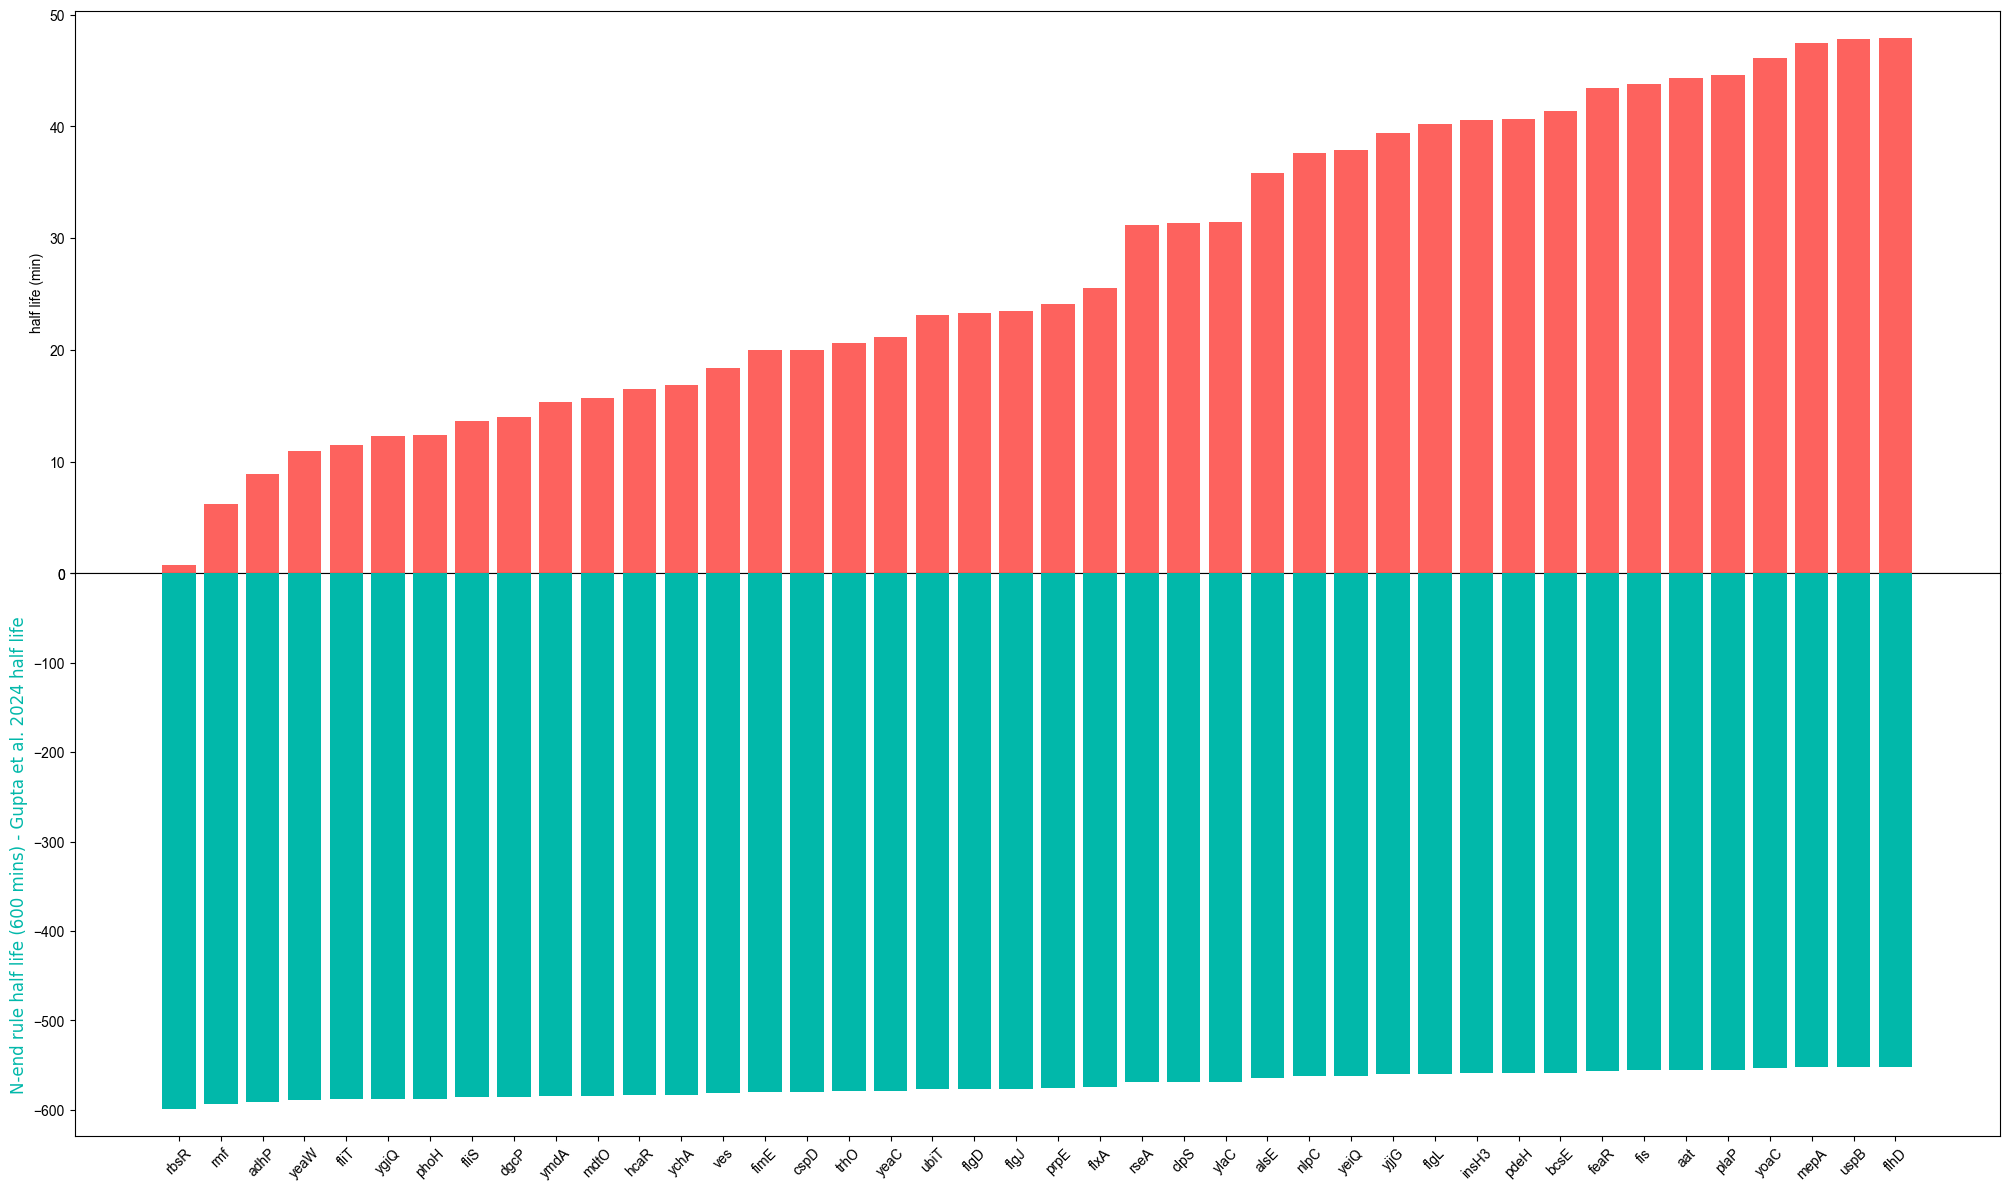

In [66]:
# using this thing: https://sharkcoder.com/data-visualization/mpl-bidirectional

font_color = '#525252'
hfont = {'fontname':'Calibri'}
#facecolor = '#eaeaf2'
color_red = '#fd625e'
color_blue = '#01b8aa'
index = data.index
column0 = data['half_life_(min)']
column1 = data['difference']
title0 = 'half life (Gupta et al. 2024)'
title1 = 'N-end rule half life (600 mins) - Gupta et al. 2024 half life'

fig, axes = plt.subplots(figsize=(25,15),  nrows=2, sharex=True)
fig.tight_layout()

axes[0].bar(index, column0, align='center', color=color_red, zorder=10)
#axes[0].set_title(title0, fontsize=18, pad=15, color=color_red, **hfont)
axes[1].bar(index, column1, align='center', color=color_blue, zorder=10)
#axes[1].set_title(title1, fontsize=18, pad=15, color=color_blue, **hfont)


axes[0].set(xticks=data.index, xticklabels=data.index)
axes[0].xaxis.tick_bottom()
axes[0].tick_params(axis='y', colors='white',) # tick color
    
axes[1].set(xticks=data.index, xticklabels=data.index)
for tick in axes[1].get_xticklabels():
    tick.set_rotation(45)

axes[0].set_ylabel('half life (min)')
axes[1].set_ylabel('N-end rule half life (600 mins) - Gupta et al. 2024 half life', fontsize=12, color=color_blue, **hfont)

plt.subplots_adjust(hspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)
